# Transferência de Estilo com Deep Learning

Este notebook é baseado no conteúdo do [github da Udacity para o Deep Learning Nanodegree](https://github.com/udacity/deep-learning-v2-pytorch).

Neste notebook, iremos replicar a técnica de transferência de estilo em PyTorch descrita neste paper: [Image Style Transfer Using Convolutional Neural Networks, by Gatys](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf).

Este paper utiliza a VGG com 19 layers para extrair features. Essa rede é composta por camadas convolucionais e de pooling. Na imagem abaixo, Conv_1_1 indica a primeira camada convolucional do primeiro conjunto de camadas. Conv_2_1 indica a primeira camada convolucional do segundo conjunto de camadas. A camada convolucional mais profunda nessa rede é a Conv_5_4.

<img src='notebook_ims/vgg19_convlayers.png' width=80% />

### Separando Estilo e Conteúdo

Transferência de estilo consiste em separar o conteúdo e o estilo de uma imagem. Dadas uma imagem de conteúdo e uma imagem de estilo, queremos criar uma nova imagem _target_ que deve conter os componentes de conteúdo e de estilo desejados:
* objetos e suas disposições são a **imagem de conteúdo**
* estilo, cores e texturas são a **imagem de estilo**

O exemplo abaixo exibe a imagem de conteúdo (um gato) e uma image de estilo ([Hokusai's Great Wave](https://en.wikipedia.org/wiki/The_Great_Wave_off_Kanagawa)).

A imagem _target_ gerada ainda contém o gato, mas ele está estilizado com as ondas, as cores azul e bege e blocos de texturas da imagem de estilo!

<img src='notebook_ims/style_tx_cat.png' width=80% />

Iremos utilizar a VGG19 pré-treinada para extrair conteúdo ou features de estilo de uma imagem. Iremos formalizar, mais para frente, os conceitos de _loss_ de conteúdo e de estilo, e utilizá-las de forma iterativa para atualizar nossa imagem _target_ até que consigamos o resultado que queremos.

In [1]:
%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

## Carregando a VGG19 (features)

A VGG199 é dividida em duas partes:
* `vgg19.features`, que possui todas as camadas convolucionais e de pooling
* `vgg19.classifier`, que possui o classificador formado por três camadas lineares

Nós precisamos apenas da parte `features`, cujos pesos iremos carregar e "congelar".

In [2]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

### Carregando As Imagens de Conteúdo e de Estilo

Você pode carregar as imagens que quiser. A função abaixo nos permite carregar uma imagem de qualquer tipo e tamanho.

A função `load_image` também converte as imagens para Tensors normalizados.

Será mais fácil termos imagens menores e termos as imagens de conteúdo e estilo reduzidas para as mesmas dimensões.

In [4]:
def load_image(img_path, max_size=200, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

Agora, iremos carregar os arquivos das imagens e forçaremos a imagem de estilo para o mesmo tamanho da imagem de conteúdo.

In [28]:
# load in content and style image
content = load_image('images/voronoi.jpg').to(device)
# Resize style to match content, makes code easier
style = load_image('images/grito.jpg', shape=content.shape[-2:]).to(device)

In [29]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

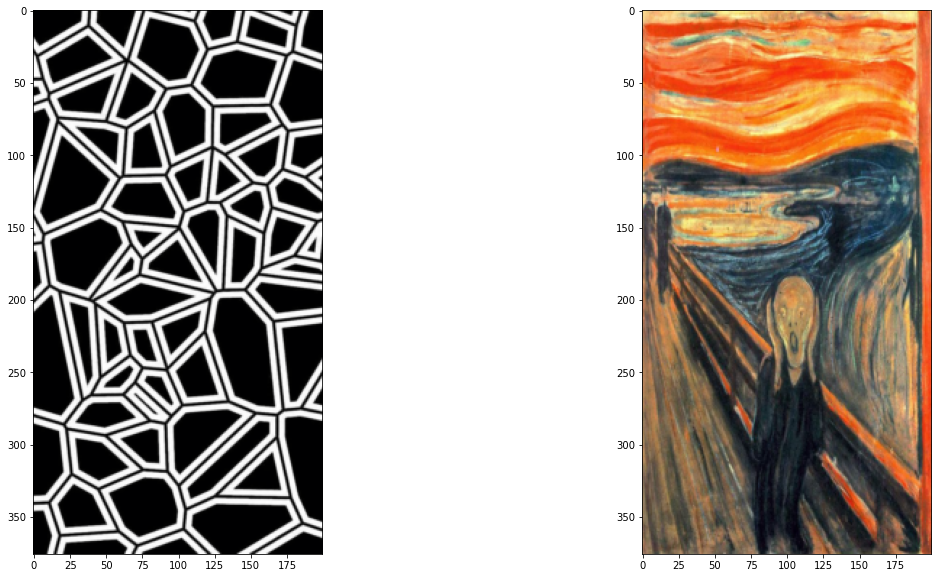

In [30]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

---
## Camadas da VGG19

Para obtermos as representações de conteúdo e de estilo de uma imagem, devemos passar a imagem através da rede VGG19 até chegarmos nas camadas desejadas e, então, pegaremos a saída dessa camada.

In [31]:
# print out VGG19 structure so you can see the names of various layers
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Features de Conteúdo e de Estilo

Na célula abaixo, iremos dar nomes às camadas de acordo com os nomes no paper para a _representação de conteúdo_ e para a _representação de estilo_.

In [32]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

---
## Matriz Gram

A saída de cada camada convolucional é um Tensor cujas dimensões estão associadas ao `batch_size`, uma profundidade `d` e alguma altura e largura (`h`, `w`). A matriz Gram de uma camada convolucional é calculada conforme abaixo:
* Pegamos a profundidade, altura e largura do tensor usando `batch_size, d, h, w = tensor.size`
* Redimensionamos esse tensor de tal forma que as dimensões espaciais sejam achatadas (flattened)
* Calculamos a matriz Gram por meio da multiplicação do tensor redimensionado por sua transposta

*Nota: podemos multiplicar duas matrizes utilizando `torch.mm(matrix1, matrix2)`.*

In [33]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

## Ligando Os Pontos

Agora que já escrevemos funções para extrair features e calcular a matriz Gram de uma camada convolucional, vamos ligar os pontos. Iremos extrair nossas features das imagens e calcular as matrizes Gram para cada camada na nossa representação de estilo.

In [34]:
# get content and style features only once before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start off with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

---
## Loss e Pesos

#### Pesos de Estilo de Camada Individual

Na célula abaixo, você terá a oportunidade de dar pesos para cada camada relevante. É sugerido que você utilize pesos no intervalo 0-1. Aumentando o peso em layers mais próximos do começo da rede (`conv1_1` e `conv2_1`), é esperado alcançar artefatos de estilo _maiores_ na imagem final. Por outro lado, caso você opte por aumentar os pesos das camadas finais, a ênfase será dada em features menores.

Isso ocorre porque cada camada possui um tamanho diferente e, juntas, elas criam uma representação de estilo multi-escala.

#### Pesos de Conteúdo e Estilo

Assim como no paper, iremos definir um alpha (`content_weight`) e um beta (`style_weight`).

Essa taxa irá afetar o quão estilizada a imagem final será. É recomendado utilizar `content_weight = 1` e ajustar o `style_weight` para alcançar a relação desejada.

In [37]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
'''style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}
content_weight = 1  # alpha
style_weight = 1e6  # beta
'''
style_weights = {'conv1_1': 1,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}
content_weight = 0.1  # alpha
style_weight = 1e6  # beta

## Atualizando o Target e Calculando as Losses

Aqui, iremos decidir a quantidade de épocas em que iremos atualizar nossa imagem. Será algo similar ao loop de treinamento que temos feito até hoje, porém estaremos alterando apenas nossa imagem de saída (nada na VGG19 nem em outras imagens).

**São recomendados pelo menos 2000 épocas para alcançar bons resultados**. Entretanto, comece com um valor bem menor apenas para testar seu código com diferentes pesos, parâmetros e imagens.

Dentro do loop de treinamento, iremos calcular as losses de conteúdo e de estilo, e atualizar a imagem de saída.

#### Loss de Conteúdo

A loss de conteúdo será a diferença média quadrática entre as features do target e do conteúdo na camada `conv4_2`. Isso será calculado da seguinte maneira:
```
content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
```

#### Loss de Estilo

A loss de estilo é calculada de forma similar, porém iremos iterar ao longo das camadas especificadas por `name` no nosso dicionário `style_weights`.
> Calcularemos a matriz Gram para a imagem target (`target_gram`) e para a imagem de estilo (`style_gram`) em cada uma das camadas e compararemos essas matrizes Gram, calculando o `layer_style_loss`.
> Depois, esse valor será normalizado pelo tamanho da camada.

#### Loss Total

Por fim, iremos calcular a loss total somando as duas losses calculadas acima e as pesando de acordo com alpha e beta.

Iremos imprimir, de tempos em tempos, essa loss. Não se assuste se ela for bem alta. Demora um bom tempo para que o estilo de uma imagem mude e você deve focar na aparência da imagem de saída, então não se preocupe com o valor da loss. Entretanto, note que esse valor decresce com o tempo.

Total loss:  924587008.0


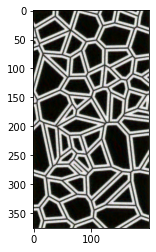

Total loss:  630583296.0


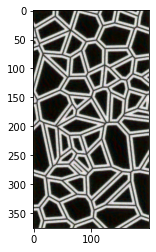

Total loss:  448939072.0


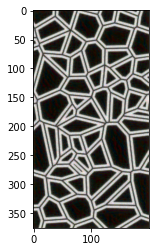

Total loss:  331138880.0


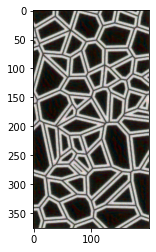

Total loss:  251588816.0


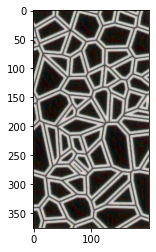

Total loss:  196079616.0


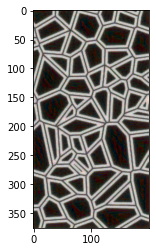

Total loss:  156264240.0


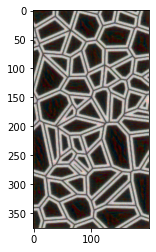

Total loss:  127012152.0


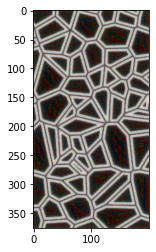

Total loss:  105071560.0


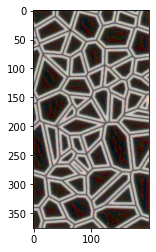

Total loss:  88309648.0


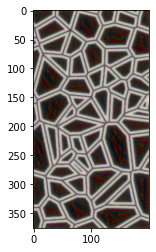

Total loss:  75280792.0


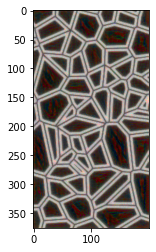

Total loss:  65012584.0


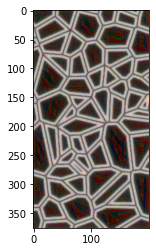

Total loss:  56808812.0


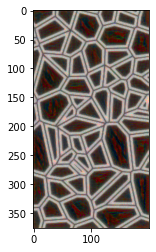

Total loss:  50177916.0


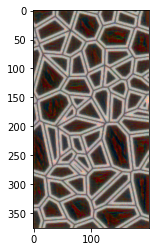

Total loss:  44753256.0


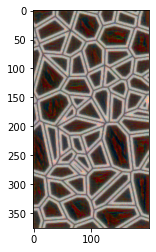

Total loss:  40260020.0


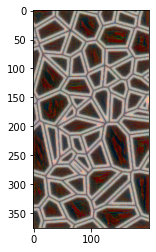

Total loss:  36502636.0


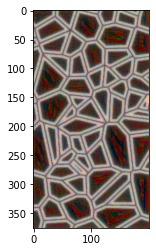

Total loss:  33325382.0


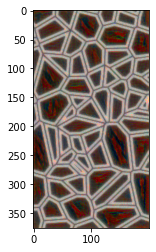

Total loss:  30611396.0


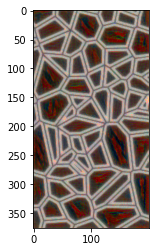

Total loss:  28271504.0


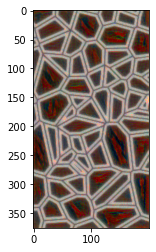

In [38]:
# for displaying the target image, intermittently
show_every = 50

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 1000  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):
    
    # get the features from your target image
    target_features = get_features(target, vgg)
    
    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

## Visualizando a Imagem Final

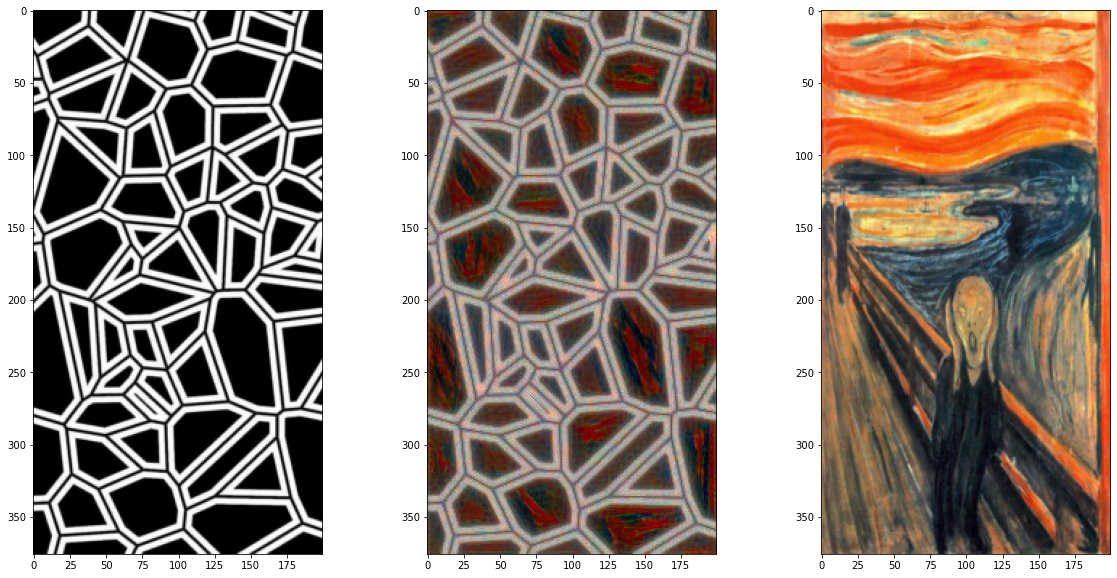

In [39]:
# display content and final, target image
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))
ax3.imshow(im_convert(style))

# Mini-projeto

Não se desesperem! Este mini-projeto será apenas para diversão. Teste diferentes imagens de estilo e de conteúdo, altere os parâmetros que vimos no decorrer deste notebook e tente gerar resultados legais.

Uma sugestão: aumente as dimensões da imagem que será processada (na função `load_image`) e tente gerar alguma imagem estilizada de resolução HD ou até mesmo 4K.